In [ ]:
library(pacman)
p_load(tidyverse, DESeq2, ggrepel, UpSetR, plyranges, data.table, ggvenn, cowplot, ashr)

In [ ]:
samples <- read_tsv("../analysis/sample.txt", show_col_types = FALSE) %>% 
            mutate(group = str_replace(group, "clone", "treatment")) %>% 
            rename("group" = "treatment") %>% 
            mutate("run" = sample) %>% 
            column_to_rownames("run")

## FeatureCounts output matrix
t_counts <- read_tsv(
    "../results/feature_counts/new7122023_count_data.txt", 
    skip = 1, 
    show_col_types = FALSE) %>% 
    dplyr::select(-Chr, -Start, -End, -Strand, -Length) 

c_counts <- read_tsv(
    "../results/feature_counts/s2_count_data.txt", 
    skip = 1, 
    show_col_types = FALSE) %>% 
    dplyr::select(-Chr, -Start, -End, -Strand, -Length) 

count_mat <- inner_join(t_counts, c_counts, by = "Geneid") %>% 
    column_to_rownames("Geneid") %>% 
    as.matrix()
# colnames(count_mat)

# rename column names of the matrix to match meta data info
colnames(count_mat) <- rownames(samples)


In [30]:
# generate DESeqDataSet
dds <- DESeqDataSetFromMatrix(countData = count_mat,
                              colData = samples,
                              design = ~ treatment)
keep <- rowSums(counts(dds)) > 10
dds <- dds[keep,]

# perform DE analysis
dds <- DESeq(dds, quiet = FALSE)

dim(dds) # dim = 21,999 29
resultsNames(dds)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 103 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] 25806    18

[1] "Intercept"                        "treatment_treatment14_vs_control"
[3] "treatment_treatment15_vs_control" "treatment_treatment16_vs_control"

using ntop=500 top features by variance



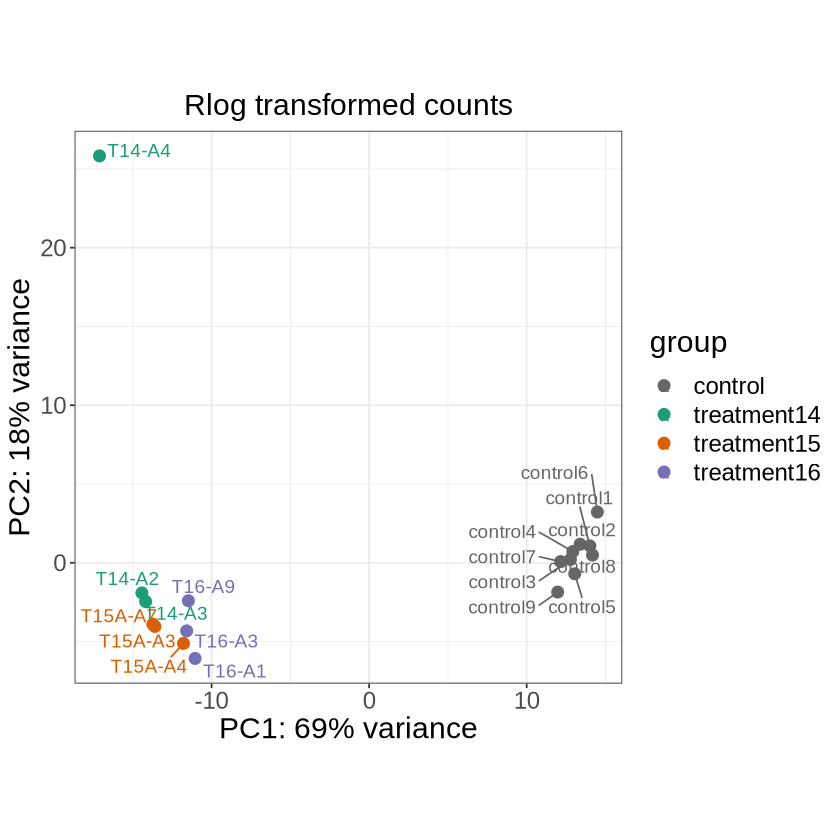

In [37]:
rlg_blind <- rlog(dds, blind=TRUE)
colors <- c('#666666','#1b9e77','#d95f02','#7570b3')
p <- plotPCA(rlg_blind, intgroup = "treatment")
p <- p + theme_bw() + ggtitle("Rlog - blind") +
scale_color_manual(values = colors) +
geom_text_repel(aes(label = name), max.overlaps = 25, size = 4) +
labs(legend = "Clones", title = "Rlog transformed counts") +
theme(text = element_text(size=18),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1)))
print(p)
#ggsave("../plots/PCA_blinded.pdf", width = 12, height = 9)

### Remove outliers

In [46]:
# remove T14-A4 

samples_woo <- samples %>% 
filter(!sample == "T14-A4") 

count_mat_woo <- count_mat[, -3]

# generate DESeqDataSet
dds_woo <- DESeqDataSetFromMatrix(countData = count_mat_woo,
                              colData = samples_woo,
                              design = ~ treatment)
keep <- rowSums(counts(dds_woo)) > 10
dds_woo <- dds_woo[keep,]

# perform DE analysis
dds_woo <- DESeq(dds_woo, quiet = FALSE)

dim(dds_woo) # dim = 21,999 29
resultsNames(dds_woo)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 8 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] 25551    17

[1] "Intercept"                        "treatment_treatment14_vs_control"
[3] "treatment_treatment15_vs_control" "treatment_treatment16_vs_control"

using ntop=500 top features by variance



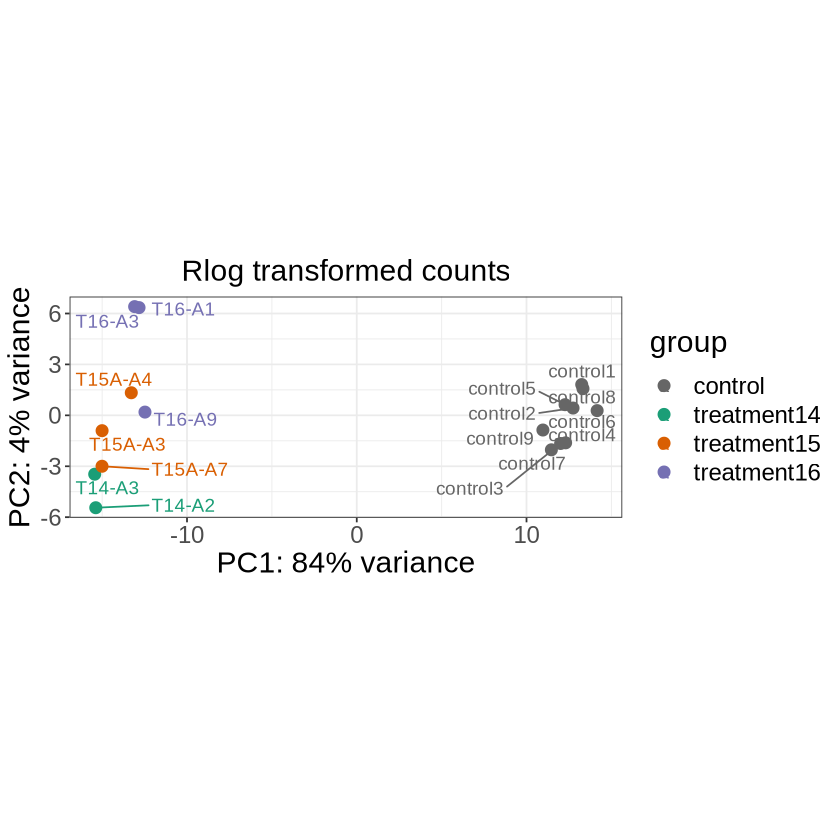

In [54]:
rlg_blind_woo <- rlog(dds_woo, blind=TRUE)
colors <- c('#666666','#1b9e77','#d95f02','#7570b3')
p <- plotPCA(rlg_blind_woo, intgroup = "treatment")
p <- p + theme_bw() + ggtitle("Rlog - blind") +
scale_color_manual(values = colors) +
geom_text_repel(aes(label = name), max.overlaps = 25, size = 4) +
labs(legend = "Clones", title = "Rlog transformed counts") +
theme(text = element_text(size=18),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1)))
print(p)
#ggsave("../plots/PCA_blinded_woo.pdf", width = 8, height = 4)



### Treatment 14 vs control

In [104]:
t14_rev <- results(dds_woo, 
                      contrast=c("treatment","treatment14","control"),
                      cooksCutoff = TRUE, 
                      independentFiltering = TRUE,
                      alpha = 0.01,
                      pAdjustMethod = "bonferroni")
t14_rev_shrk <- lfcShrink(dds=dds_woo, res=t14_rev, type = "ashr") 
summary(t14_rev_shrk)

t14_rev_shrk_df <- as_tibble(t14_rev_shrk, rownames = "gene") %>% 
    filter(!is.na(padj) & padj < 0.01 & abs(log2FoldChange) > 1) %>% 
    arrange(padj) %>% 
    distinct() %>% 
    write_tsv("../results/deg/clone14_lfcshrk1_p0.01.tsv")
length(unique(t14_rev_shrk_df$gene))


using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 25551 with nonzero total read count
adjusted p-value < 0.01
LFC > 0 (up)       : 1862, 7.3%
LFC < 0 (down)     : 2529, 9.9%
outliers [1]       : 8, 0.031%
low counts [2]     : 3468, 14%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] 1485

### Treatment 15 vs control

In [105]:
t15_rev <- results(dds_woo, 
                      contrast=c("treatment","treatment15","control"),
                      cooksCutoff = TRUE, 
                      independentFiltering = TRUE,
                      alpha = 0.01,
                      pAdjustMethod = "bonferroni")
t15_rev_shrk <- lfcShrink(dds=dds_woo, res=t15_rev, type = "ashr") 
summary(t15_rev_shrk)

t15_rev_shrk_df <- as_tibble(t15_rev_shrk, rownames = "gene") %>% 
    filter(!is.na(padj) & padj < 0.01 & abs(log2FoldChange) > 1) %>% 
    arrange(padj) %>% 
    distinct() %>% 
    write_tsv("../results/deg/clone15_lfcshrk1_p0.01.tsv")
length(unique(t15_rev_shrk_df$gene))


using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 25551 with nonzero total read count
adjusted p-value < 0.01
LFC > 0 (up)       : 2329, 9.1%
LFC < 0 (down)     : 2863, 11%
outliers [1]       : 8, 0.031%
low counts [2]     : 3468, 14%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] 1592

### Treatment 16 vs control

In [106]:
t16_rev <- results(dds_woo, 
                      contrast=c("treatment","treatment16","control"),
                      cooksCutoff = TRUE, 
                      independentFiltering = TRUE,
                      alpha = 0.01,
                      pAdjustMethod = "bonferroni")
t16_rev_shrk <- lfcShrink(dds=dds_woo, res=t16_rev, type = "ashr") 
summary(t16_rev_shrk)

t16_rev_shrk_df <- as_tibble(t16_rev_shrk, rownames = "gene") %>% 
    filter(!is.na(padj) & padj < 0.01 & abs(log2FoldChange) > 1) %>% 
    arrange(padj) %>% 
    distinct() %>% 
    write_tsv("../results/deg/clone16_lfcshrk1_p0.01.tsv")
length(unique(t16_rev_shrk_df$gene))


using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 25551 with nonzero total read count
adjusted p-value < 0.01
LFC > 0 (up)       : 2298, 9%
LFC < 0 (down)     : 2339, 9.2%
outliers [1]       : 8, 0.031%
low counts [2]     : 3963, 16%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] 1251

Warning message:
“Removed 4 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


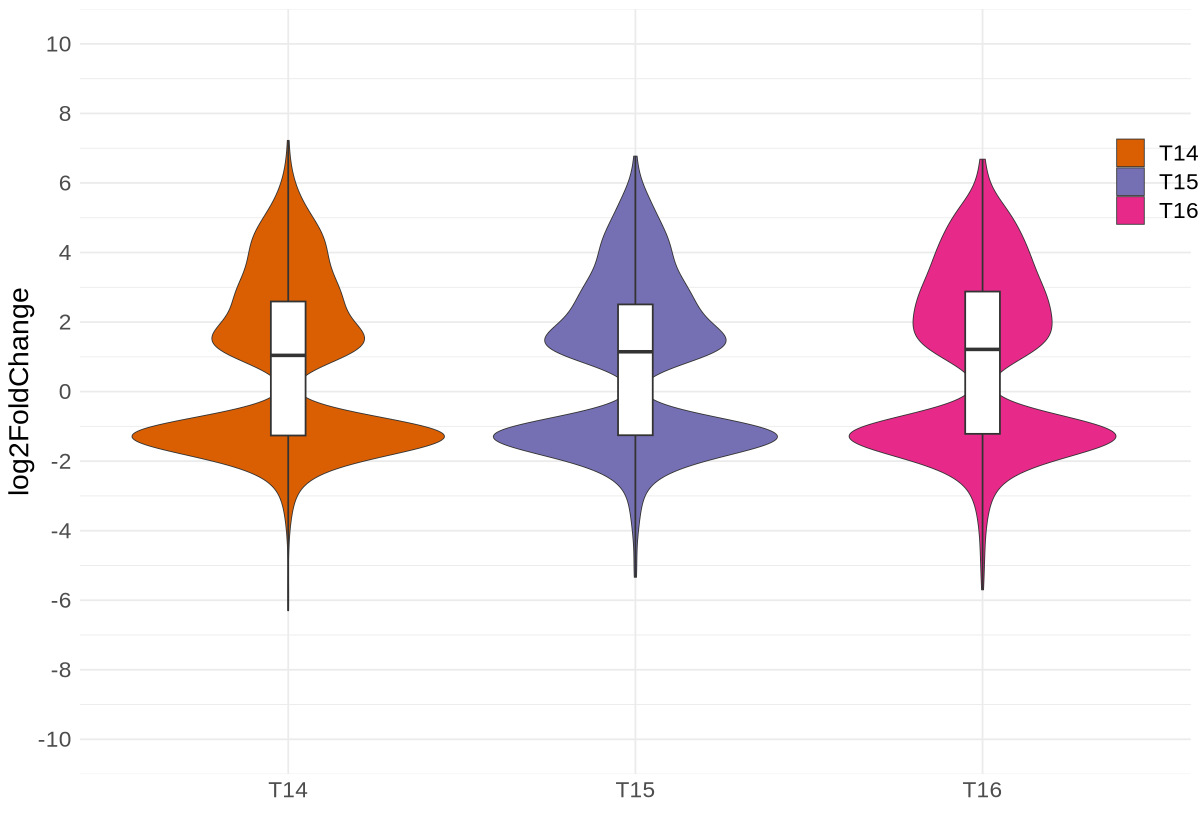

In [110]:
t14 <- read_tsv("../results/deg/clone14_lfcshrk1_p0.01.tsv",
                      show_col_types= FALSE) %>% 
    mutate(clone = "T14")
t15 <- read_tsv("../results/deg/clone15_lfcshrk1_p0.01.tsv",
                      show_col_types= FALSE) %>% 
    mutate(clone = "T15")
t16 <- read_tsv("../results/deg/clone16_lfcshrk1_p0.01.tsv",
                      show_col_types= FALSE) %>% 
    mutate(clone = "T16")

all_target_df <- bind_rows(t14, t15, t16) 

# min(all_target_df$log2FoldChange)
# max(all_target_df$log2FoldChange)

all_target_df$clone <- factor(all_target_df$clone, levels = c("T14", "T15", "T16"))

colors <- c('#d95f02','#7570b3','#e7298a','#66a61e')

all_target_df %>% 
ggplot(aes(x = clone, y = log2FoldChange, fill = clone)) +
geom_violin(trim=TRUE, linewidth = 0.25) +
geom_boxplot(width=0.1, fill = "white", outlier.size = 1) +
scale_fill_manual(values = colors) +
scale_y_continuous(limits = c(-10, 10), breaks = seq(-10, 10, 2)) +
labs(x="", fill = "") +
theme_minimal() +
theme(legend.position = c(0.97, 0.8),
        text = element_text(size=17),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1)))
ggsave("../plots/log2fc_violin.pdf", width = 8, height = 6)

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


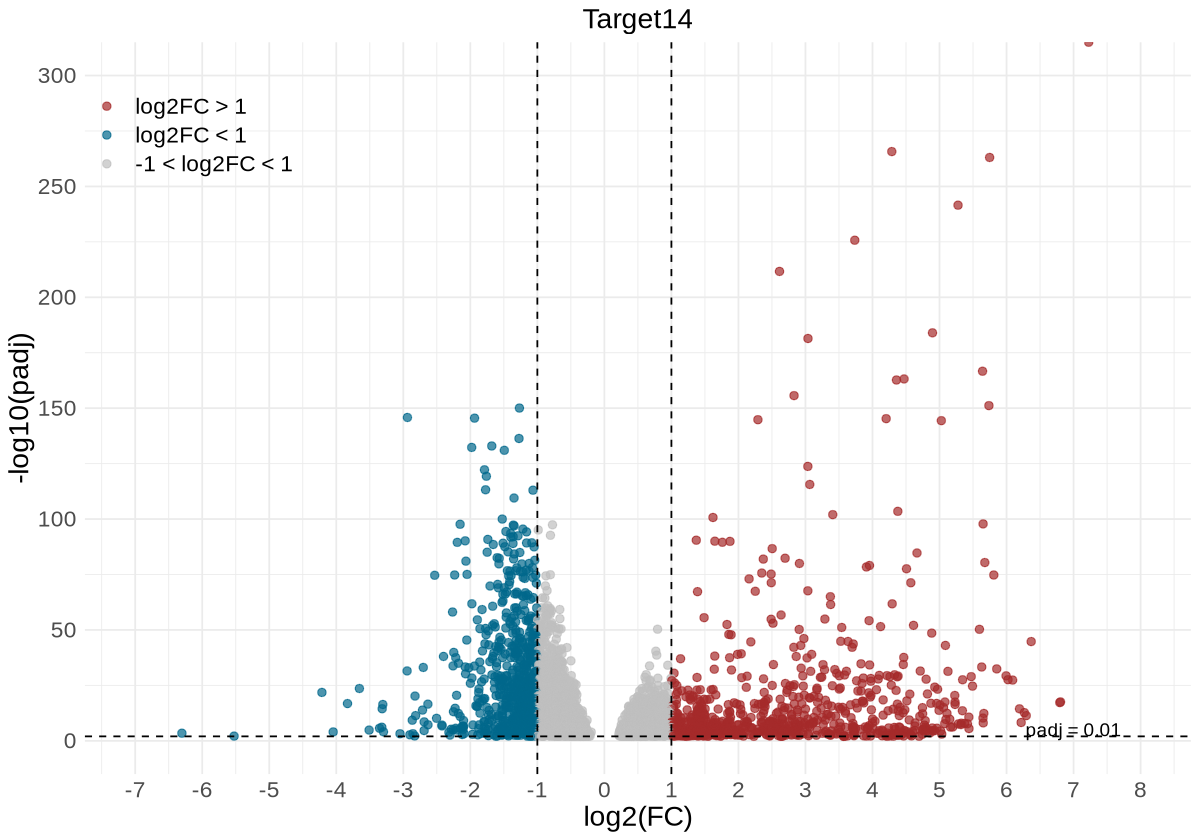

In [133]:
t14 <- as_tibble(t14_rev_shrk, rownames = "gene") %>% 
    filter(!is.na(padj) & padj < 0.01 & abs(log2FoldChange) > 0) %>% 
    arrange(padj) %>% 
    distinct()
t14$diffexp <- ""
t14$diffexp[t14$log2FoldChange > 1 & t14$padj < 0.01] <- "log2FC > 1"
t14$diffexp[t14$log2FoldChange < -1 & t14$padj < 0.01] <- "log2FC < 1"
t14$diffexp[t14$log2FoldChange > -1 & t14$log2FoldChange < 1 & t14$padj < 0.01] <- "-1 < log2FC < 1"
t14$diffexp <- factor(t14$diffexp, levels = c("log2FC > 1", "log2FC < 1", "-1 < log2FC < 1"))
options(repr.plot.width = 10, repr.plot.height = 7)
ggplot(t14) +
  geom_point(aes(x=log2FoldChange, y=-log10(padj), color = diffexp), alpha = 0.7, size = 2) +
  geom_vline(xintercept = c(-1, 1), col = "black", linetype = 'dashed') +
  geom_hline(yintercept = -log10(0.01), col = "black", linetype = 'dashed') +
  annotate("text", x=7, y=5, label="padj = 0.01", size = 4) +
  scale_colour_manual(values = c("brown", "deepskyblue4", "gray")) +
  scale_x_continuous(limits = c(-7, 8), breaks = seq(-7, 8, 1)) +
  scale_y_continuous(limits = c(0, 300), breaks = seq(0, 300, 50)) +
  ggtitle("Target14") +
  xlab("log2(FC)") + 
  ylab("-log10(padj)") +
  labs(color = "") +
  theme_minimal() +
  theme(legend.position = c(0.1, 0.9),
        text = element_text(size=17),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1)))  
ggsave("../plots/t14_log2fc_scatterp.pdf", width = 10, height = 7)

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


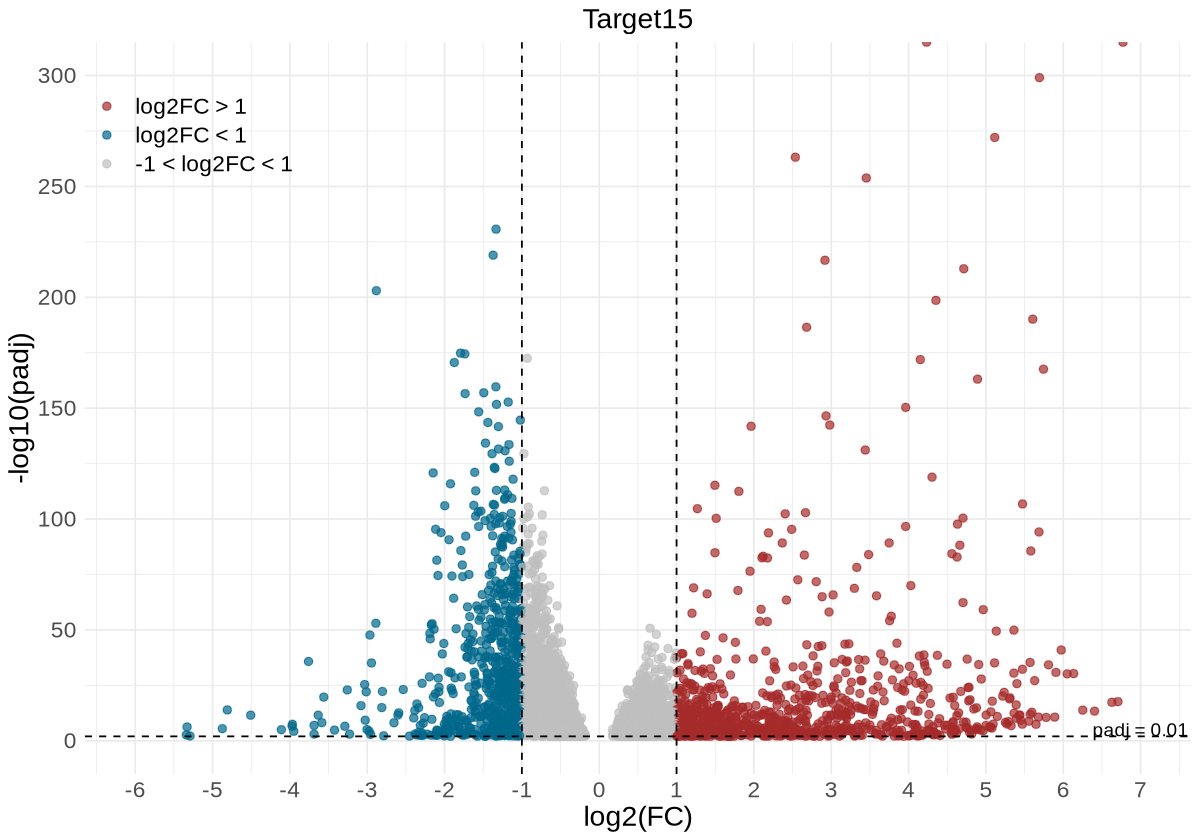

In [134]:
t15 <- as_tibble(t15_rev_shrk, rownames = "gene") %>% 
    filter(!is.na(padj) & padj < 0.01 & abs(log2FoldChange) > 0) %>% 
    arrange(padj) %>% 
    distinct()
t15$diffexp <- ""
t15$diffexp[t15$log2FoldChange > 1 & t15$padj < 0.01] <- "log2FC > 1"
t15$diffexp[t15$log2FoldChange < -1 & t15$padj < 0.01] <- "log2FC < 1"
t15$diffexp[t15$log2FoldChange > -1 & t15$log2FoldChange < 1 & t15$padj < 0.01] <- "-1 < log2FC < 1"
t15$diffexp <- factor(t15$diffexp, levels = c("log2FC > 1", "log2FC < 1", "-1 < log2FC < 1"))
options(repr.plot.width = 10, repr.plot.height = 7)
ggplot(t15) +
  geom_point(aes(x=log2FoldChange, y=-log10(padj), color = diffexp), alpha = 0.7, size = 2) +
  geom_vline(xintercept = c(-1, 1), col = "black", linetype = 'dashed') +
  geom_hline(yintercept = -log10(0.01), col = "black", linetype = 'dashed') +
  annotate("text", x=7, y=5, label="padj = 0.01", size = 4) +
  scale_colour_manual(values = c("brown", "deepskyblue4", "gray")) +
  scale_x_continuous(limits = c(-6, 7), breaks = seq(-6, 7, 1)) +
  scale_y_continuous(limits = c(0, 300), breaks = seq(0, 300, 50)) +
  ggtitle("Target15") +
  xlab("log2(FC)") + 
  ylab("-log10(padj)") +
  labs(color = "") +
  theme_minimal() +
  theme(legend.position = c(0.1, 0.9),
        text = element_text(size=17),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1)))  
ggsave("../plots/t15_log2fc_scatterp.pdf", width = 10, height = 7)

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


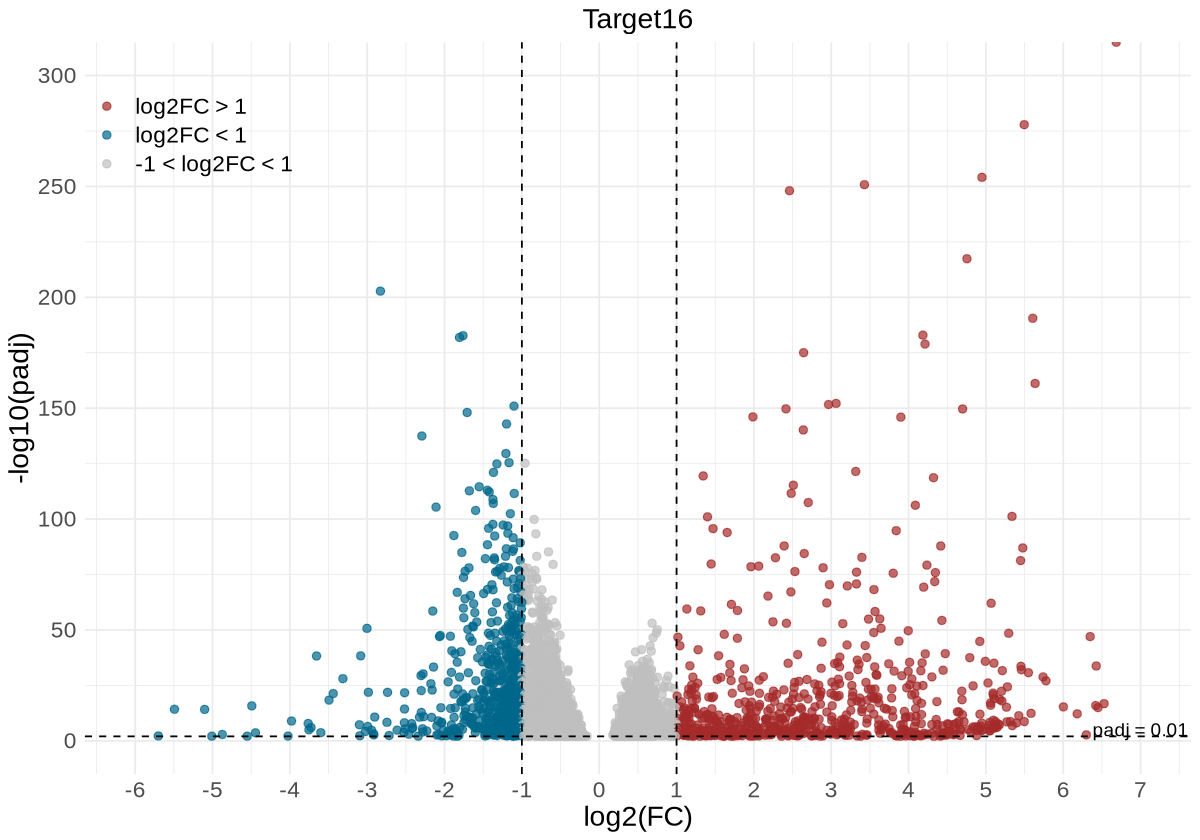

In [135]:
t16 <- as_tibble(t16_rev_shrk, rownames = "gene") %>% 
    filter(!is.na(padj) & padj < 0.01 & abs(log2FoldChange) > 0) %>% 
    arrange(padj) %>% 
    distinct()
t16$diffexp <- ""
t16$diffexp[t16$log2FoldChange > 1 & t16$padj < 0.01] <- "log2FC > 1"
t16$diffexp[t16$log2FoldChange < -1 & t16$padj < 0.01] <- "log2FC < 1"
t16$diffexp[t16$log2FoldChange > -1 & t16$log2FoldChange < 1 & t16$padj < 0.01] <- "-1 < log2FC < 1"
t16$diffexp <- factor(t16$diffexp, levels = c("log2FC > 1", "log2FC < 1", "-1 < log2FC < 1"))
options(repr.plot.width = 10, repr.plot.height = 7)
ggplot(t16) +
  geom_point(aes(x=log2FoldChange, y=-log10(padj), color = diffexp), alpha = 0.7, size = 2) +
  geom_vline(xintercept = c(-1, 1), col = "black", linetype = 'dashed') +
  geom_hline(yintercept = -log10(0.01), col = "black", linetype = 'dashed') +
  annotate("text", x=7, y=5, label="padj = 0.01", size = 4) +
  scale_colour_manual(values = c("brown", "deepskyblue4", "gray")) +
  scale_x_continuous(limits = c(-6, 7), breaks = seq(-6, 7, 1)) +
  scale_y_continuous(limits = c(0, 300), breaks = seq(0, 300, 50)) +
  ggtitle("Target16") +
  xlab("log2(FC)") + 
  ylab("-log10(padj)") +
  labs(color = "") +
  theme_minimal() +
  theme(legend.position = c(0.1, 0.9),
        text = element_text(size=17),
        plot.title = element_text(size = rel(1), hjust = 0.5),
        axis.title = element_text(size = rel(1)))  
ggsave("../plots/t16_log2fc_scatterp.pdf", width = 10, height = 7)